<style>
    
    h1 {
      display: block;
      max-width: 100%;
      margin-left: auto;
      margin-right: auto;
      text-align: center;
      font-family: "Arial";
      font-size: 32px;
      line-height: 60px;
      font-style: normal;
    }
    
    h2 {
      font-family: "Arial", serif;
      font-size: 24px;
    }

    h3 {
      font-family: "Arial", serif;
      font-size: 20px;
    }

    h4 {
      text-align: center;
      font-size: 20px;
    }

    h5 {
      font-family: "Arial", serif;
      font-size: 16px;
      font-style: oblique;
    }

    div.text_cell_render {
      padding-left: 5%;
      padding-right: 5%;
      width: 90%;
      font-family: "Tahoma", serif;
      font-size: 14px;
    }
    
</style>


<br>
<div align="center"><h1>Pyeongchang Olympic medal ranker<br>web scraper</h1></div>

<br><br>
<h5>Faraz Babaei, 2018-2-16 ~ 17</h5>
<br>

<h2>Intro</h2>

<br>Many media networks present arbitrary based rankings of countries based on medals won (their numbers and types). More commonly, the nations are ranked based on the total number of medals regardless of the type [1,1,1], some rank on a type of medal at a time. Here I present the code to arbitrarily assign values to the 3 medal types, and score and rank the nations involved accordingly. The chosen setup for the visualizations given herein is arguably more reasonable than other presented ranking bases. It uses [4,2,1], the relative values assumed for the gold, silver, and bronze medals respectively.

<br><br>

<h2>Method</h2>

<br>

<p>Data of the countries participating at The Olympics and their names as well as medals won by the nations are scraped off of 2 official Olympics websites. These sets of data are analyzed to produce tables mapping the national Olympic committee (NOC) codes to country names and to summarize numbers of the different types of medals won for each NOC code. The score based on the [4,2,1] pointing system is then obtained and plotted showing international rankings in a bar plot and a choropleth. The notebook may be run through to update the produced results.</p>

<p>Two details to note for the method include: 1- MatplotlibDeprecationWarning is suppressed in Choropleth execution cell. 2. On the choropleth, OAR (Olympic athletes from Russia) is color patched as Russia (RUS).</p>

<br>

<!-- <h2><b>Results</b></h2>

<p>Nations rank well.</p>

<br> -->


In [1]:
""" Hide code segments from nbviewer output """
""" From http://protips.maxmasnick.com/hide-code-when-sharing-ipython-notebooks """
import IPython.core.display as di
# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


In [2]:
""" Conversion rate   Faraz Babaei   2018-2-16 ~ 2018-2-17 """
""" Imports and data reading """

import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
# from matplotlib.gridspec import GridSpec
from IPython.core.display import display
from mpl_toolkits.basemap import Basemap, Polygon

# import re
from time import time, sleep
from random import randint
import warnings

np.random.seed (18216)
%matplotlib inline
plt.style.use('ggplot')   # style for plots
# formats floats to show up with 4 dec. digits when display() used
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
fig_num, tbl_num = 0, 0

""" Constants """
SCR_MOD = {"G":4, "S":2, "B":1}   # Scoring model designating points to gold, silver, and bronze medals


In [3]:
""" Scraping data off web """

CTRS_URL = "https://www.olympic.org/pyeongchang-2018/results/en/general/nocs-list.htm"
MDLS_URL_1 = "https://www.pyeongchang2018.com/en/game-time/results/OWG2018/en/general/medal-standings.htm"
MDLS_URL_2 = "https://www.cnn.com/2018/02/08/sport/winter-olympics-" + \
                "2018-pyeongchang-medal-table/index.html"
MDLS_URL_3 = "http://time.com/5163230/2018-winter-olympic-medal-tracker/"

params_0, params_1 = None, None#{"lat": 37.78, "lon": -122.41}
ctrs_rsp = requests.get (CTRS_URL, params=params_0)
#sleep( randint(1,3) )   # wait 1-3 s btw requests from domain. Nvm; sites are different
mdls_rsp_1 = requests.get (MDLS_URL_1, params=params_1)

print ("Countries' site response status: ", ctrs_rsp)#.status_code)
print ("Medal info site response status: ", mdls_rsp_1)#.status_code)
# I split the cell not to keep GETting from the site, which might get angry, which is unlikely anyway.

""" Now time """

t_now = pd.to_datetime(time()*1000000000, utc=True)
t_now_kor = t_now.tz_convert('Asia/Seoul')
t_now_kor_str = t_now_kor.strftime('%Y-%m-%d %H:%M:%S')


Countries' site response status:  <Response [200]>
Medal info site response status:  <Response [200]>


In [4]:
""" Countries: Collecting them """

bsp_ctrs = BeautifulSoup ( ctrs_rsp.content, 'html.parser' )
# print (bsp.prettify())

cls_ctrs = bsp_ctrs.find_all ( class_="CountriesList" )
inf_ctrs = cls_ctrs[0].find_all( "div" )
# print ( type(inf_ctrs), len(inf_ctrs) )

ctr_names = []
ctr_codes = []

for ctr_inf in inf_ctrs:
    if len (ctr_inf.get_text().strip()) > 0:   # To exclude the div after UZB wo/ any ctr info
        
        imgs_inf = ctr_inf.find_all("img")
        ctr_flag_img_fl = imgs_inf[0]["src"].rsplit("/")[-1]
        ctr_code = ctr_flag_img_fl.split(".")[0]
        
        ctr_names.append ( ctr_inf.get_text().strip() )
        ctr_codes. append (ctr_code)


ctr_cods_nms = list(zip(ctr_codes, ctr_names))
# print ( "num countries: {}\n".format(len(ctr_cods_nms)) )
print_list = ["{}: {} {}".format(i,ccn[0],ccn[1]) for i,ccn in enumerate(ctr_cods_nms)]
tbl_num += 1
print ( "Table {}: Countries' NOC codes mapped to their names".format(tbl_num) + \
       " participating at Pyeongchang, alphabetically ordered by NOC codes." )
print ( "{}\n...\n{}".format( "\n".join(print_list[:5]), "\n".join(print_list[-5:]) ) )

ctrs_dct = {noc:nm for noc,nm in zip(ctr_codes,ctr_names)}
#print (ctrs_dct)


Table 1: Countries' NOC codes mapped to their names participating at Pyeongchang, alphabetically ordered by NOC codes.
0: ALB Albania
1: AND Andorra
2: ARG Argentina
3: ARM Armenia
4: AUS Australia
...
88: TPE Chinese Taipei
89: TUR Turkey
90: UKR Ukraine
91: USA United States of America
92: UZB Uzbekistan


In [5]:
""" Medals list 1 """

# TODO: Medal counts. Try collecting them from 2 sources and comparing or one for backup!
bsp_mdls_1 = BeautifulSoup ( mdls_rsp_1.content, 'html.parser' )
# print (bsp.prettify())

cls_mdls = bsp_mdls_1.find_all ( class_="ResTableFull" )
#print (cls_mdls)
mdl_trs = cls_mdls[0].find_all( "tr" )
# print ( type(mdl_trs), len(mdl_trs) )

INI_MDLS_DCT = {"G":0, "S":0, "B":0}
mdls_dict = {k:INI_MDLS_DCT.copy() for k in ctr_codes}

# Note: If the website format changes in any form, the following will most probably not work!
    # Not working is preferred to producing the wrong info, we've made sure it does disbehave rather than misbehave
# TODO: Change Note above
# TODO: Implement call-catch exceptions?

for td_coll in mdl_trs[1:]:   # index 0 contains table heading actually
    for td in td_coll.find_all( "td" )[2:-1]:
        for link_inf in td.find_all("a"):
            # TODO: We're ignoring some redundant structure of the html page here, the table rows.
            tbl_cell_ttl = link_inf["title"].split()[0]
            noc_code = tbl_cell_ttl[:3]
            mdl_type = tbl_cell_ttl[3]
#             print (noc_code, mdl_type, int(link_inf.get_text()))

            if noc_code not in mdls_dict:
                print ("Problem: NOC not in participants list!")
            mdls_dict[noc_code][mdl_type] = int(link_inf.get_text())

# print (mdls_dict)
# for etr in mdls_dict.keys():
#     print (etr, mdls_dict[etr])


In [6]:
""" Score allocation """

# A long recursive (?) dictionry comprehension
score_by_mdl_dct = { k1:{k2:v2*SCR_MOD[k2] for k2,v2 in v1.items()} \
                    for k1,v1 in mdls_dict.items() }
scores_dct = { k1:sum([v2 for v2 in v1.values()]) \
              for k1,v1 in score_by_mdl_dct.items() }
# print (scores_dct)
scores_tpls = sorted ( scores_dct.items(), key=lambda x: (x[0]) )   # It was already sorted!
scores_tpls = sorted ( scores_dct.items(), key=lambda x: (x[1]), reverse=True )
ct_sc_sub = [ (a,ctrs_dct[a],b) for a,b in scores_tpls if b != 0 ]
# print (ct_sc_sub)

ct_scs = list( zip(*scores_tpls) )
ct_scs_sub = list( zip(*ct_sc_sub) )

scr_df = pd.DataFrame ({"Score":ct_scs_sub[2]}, index=ct_scs_sub[0])
tbl_num += 1
print ("Table {}: Some nations and their medal points at the 2018 Winter Olympics.".format(tbl_num))
display (scr_df.T)


Table 2: Some nations and their medal points at the 2018 Winter Olympics.


,NOR,GER,CAN,USA,NED,FRA,AUT,SWE,KOR,SUI,...,POL,FIN,HUN,UKR,ESP,NZL,SLO,KAZ,LAT,LIE
Score,86,71,58,52,44,34,30,30,27,26,...,5,4,4,4,2,2,2,1,1,1


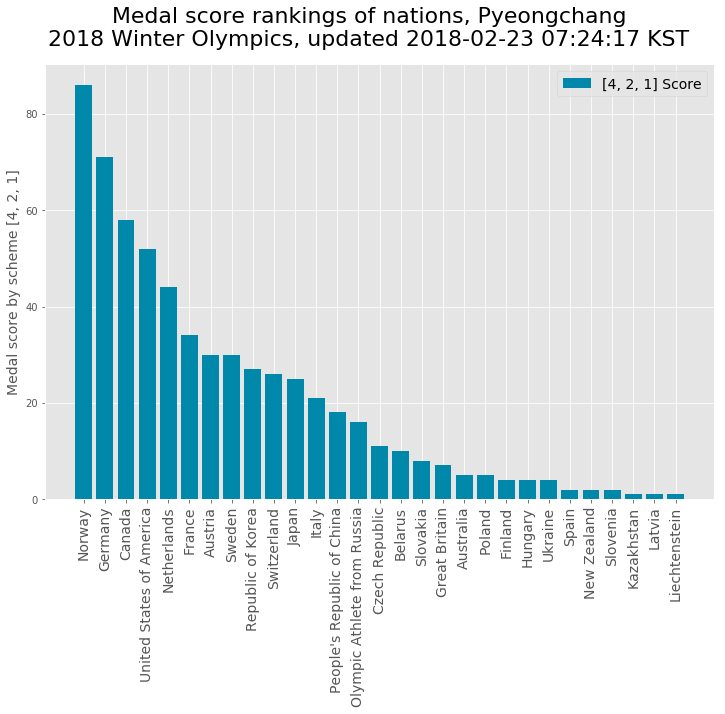

Figure 1: Medal score rankings of nations, Pyeongchang 2018 Winter Olympics, last updated 2018-02-23 07:24:17 KST.


In [7]:
""" Visualization """

fig = plt.figure(figsize=(12,8), facecolor="#ffffff")
plt.bar ( range(len(ct_scs_sub[1])), ct_scs_sub[2], align='center', \
         color='#0088aa', log=False, label="{} Score".format( list(SCR_MOD.values()) ) )
# plt.bar ( range(len(ct_scs_sub[1])), ct_scs_sub[2], align='center', log=False, label="{4,2,1} Score" )
plt.suptitle ( "Medal score rankings of nations, Pyeongchang\n"+\
              "2018 Winter Olympics, updated {} KST".format(t_now_kor_str), fontsize=22 )
plt.xticks ( range(len(ct_scs_sub[1])), ct_scs_sub[1], fontsize=14, rotation=90 )
plt.ylabel ( "Medal score by scheme {}".format( list(SCR_MOD.values()) ), fontsize=14 )
plt.legend ( loc='upper right', fontsize=14 )
plt.show()
fig_num += 1
print ("Figure {}: Medal score rankings of nations, Pyeongchang 2018 Winter".format(fig_num) + \
       " Olympics, last updated {} KST.".format(t_now_kor_str))


In [8]:
""" Choropleth functions and initiation """

def draw_map (ser, clr_inf):
    """ Function to draw choropleth based on input pandas Series and color map in "robin" world map projection """
    lMax = ser.max()    # lMin would be zero
    clr_vals = {}
    
    for ctr in ser.index:
        score = ser.loc[ctr]
        try:
            # C[C["IOCode"]==ctr]["ISO_3"]  finds ISO_3 col of row where this row's IOCode col has ctr.
            # Segment above returns a Series. So I had to to .tolist()[0] to retrieve its only elem
            key = ctr_nm_map[ctr_nm_map["IOCode"]==ctr]["ISO_3"].tolist()[0]
            clr_vals[key] = 1.0 * score / lMax   # The 1.0 used to be 0.8, but that made the color bar legend quite wrong
        except ( KeyError, IndexError ) as e:
            print ( "Hello {}".format(ctr) )
            continue   #print (e) or just ignore
    
    ini_lon = 0. #10. preferred but horizontal streaks appear from polygons of Bering islands cut off by the 10 degree boundary
    m = Basemap ( projection='robin', lon_0=ini_lon, resolution='c' )
    m.readshapefile ( 'res/ne_10m_ctr_shape/ne_10m_admin_0_countries', 'NE_10m_Countries' )
    
    m.drawmapboundary ( color='black', fill_color='#005566' )   # draw white map background and remove boundary line
    #m.drawcoastlines(color='grey')            # not exactly needed but adds definition, e.g. to Amazon river
    m.fillcontinents ( color='#222222', lake_color='#005566' )
    m.drawcountries(linewidth=1, color='grey')
    graticule_width = 30                       # spacing (in deg?) btw lon- or lat-lines on map
    graticule_color = '#333333'
    parallels = np.arange ( -90, 91, graticule_width )
    meridians = np.arange ( -180., 181., graticule_width )
    dashes = [3,5]                             # We wish to change the dashline style to 3-on, 5-off in pixels
    m.drawparallels ( parallels, dashes=dashes, color=graticule_color, linewidth=0.4 )
    m.drawmeridians ( meridians, dashes=dashes, color=graticule_color, linewidth=0.4 )
    
    ax = plt.gca()
    for info, shape in zip( m.NE_10m_Countries_info, m.NE_10m_Countries ):
        try:
            curVal = clr_vals [ info['ADM0_A3'] ]
            if np.isnan(curVal):
                color = '#222222'
            else:
                color = clr_inf[0] ( curVal**clr_inf[1] )
        except ( KeyError, IndexError ): continue
        ax.add_patch( Polygon( np.array(shape), facecolor=color, \
                              edgecolor='black', linewidth=0.4, zorder=2 ) )
    
    return


def draw_legend (clr_inf):
    """ Draw color bar legend with a cubic root color map;
    (help: http://ramiro.org/notebook/basemap-choropleth/) """
    ax_legend = fig.add_axes ( [0.26, -0.02, 0.48, 0.016], zorder=3 )
    grads = np.linspace (0.,1.,400)
    bins = np.linspace (0.,1.,11)
    scheme = [ clr_inf[0]((i/400.)**(clr_inf[1])) for i in range(400) ]
    cmap = matplotlib.colors.ListedColormap(scheme)
    cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, \
                                          ticks=bins, orientation='horizontal')  # had: boundaries=grads**CLR_PWR,
    #cb.set_xticklabels ( [str(round(i, 1)) for i in bins] )
    #cb.set_xticklabels ( color='#ddbb00', fontsize=10 )
    #cb.draw_all()
    return

# def PolyArea(x,y):
#     """ Calculates area of a 2D polygon with given corespective x,y vertex lists inspired by
#     http://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates """
#     return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

""" This portion belongs to next cell but here to suppress its output, otherwise I think impossible to suppress """
ini_lon = 0. #10. preferred but horizontal streaks appear from polygons of Bering islands cut off by the 10 degree boundary
m = Basemap ( projection='robin', lon_0=ini_lon, resolution='c' )


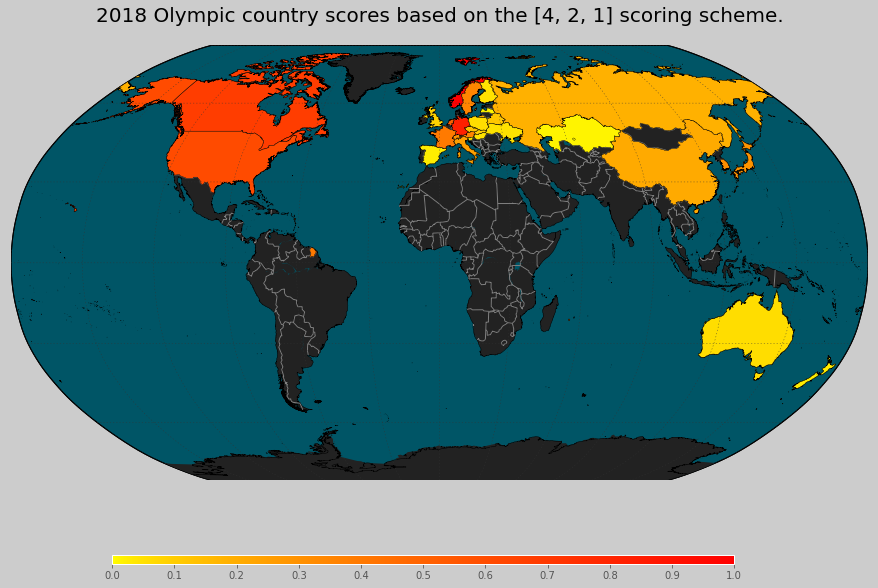

Figure 2: World choropleth with contrast based on 2018 Olympic scores in the [4, 2, 1] scoring scheme
last updated 2018-02-23 07:24:17 KST.


In [9]:
""" Choropleth """

CLR_INF = (plt.cm.autumn_r, 0.7)   # (plt.cm.autumn_r, 0.7), (rainbow, 0.25), (Wistia, 0.50), (plasma, 0.33)

ctr_nm_map = pd.read_csv ("res/country names map.tsv", sep='\t')   # country codes-name map table
scr_ser = scr_df["Score"].copy()
# OAR -> RUS for choropleth: ISO-3 code for this year's Russia Olympic exception:
scr_ser.rename ( index={'OAR': "RUS"}, inplace=True )


warnings.filterwarnings("ignore", category=UserWarning)

fig = plt.figure ( figsize=(18,8) )
fig.patch.set_facecolor ( '#cccccc' )  # map background
plt.title ( "2018 Olympic country scores based on the {} scoring scheme.".\
           format( list(SCR_MOD.values()) ), fontsize=20, y=1.04 )
draw_map ( scr_ser, CLR_INF )
draw_legend ( CLR_INF )
#fig.tight_layout ()
plt.show()
fig_num += 1
print ( "Figure {}: World choropleth with contrast based on 2018 Olympic".format(fig_num) + \
       " scores in the {} scoring scheme\nlast updated {} KST.".\
       format( list(SCR_MOD.values()), t_now_kor_str ) )

warnings.filterwarnings("default", category=UserWarning)
